# Data Exploration, Cleaning and Feature Engineering

Importing all the necessary libraries for this dataset.

In [2]:

import pandas as pd
import re
import numpy as np
import ast
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("listings.csv")
df1 = pd.read_csv("neighbourhoods.csv")
df2 = pd.read_csv("reviews.csv")

C:\Users\saadw\AppData\Local\Temp\ipykernel_1700\3426228439.py:13: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("listings.csv")


This figure below showcases how Hotel Rooms have a higher average price than the other room types. I have grouped the room type with respect to the price and then im taking its mean. 

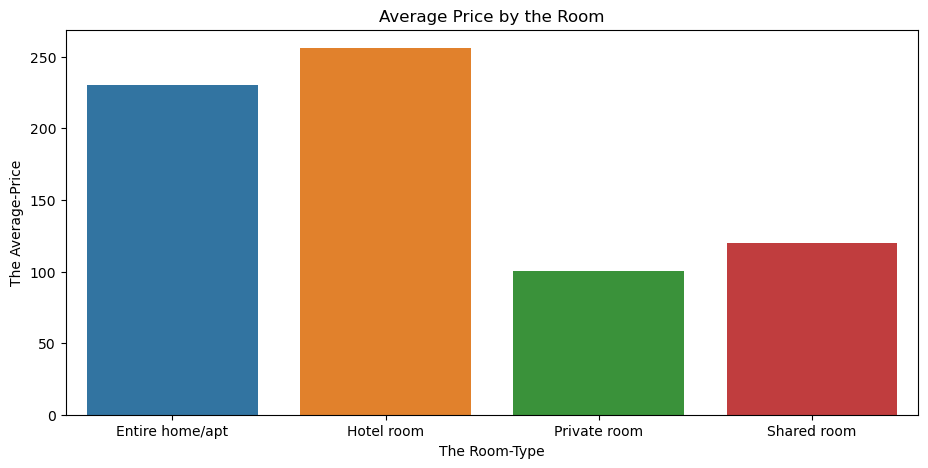

In [3]:
df['priceIs'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

averagePriceByTheRooms = df.groupby('room_type')['priceIs'].mean().reset_index()

plt.figure(figsize=(11, 5))
sns.barplot(x='room_type', y='priceIs', data=averagePriceByTheRooms)
plt.title('Average Price by the Room')
plt.xlabel('The Room-Type')
plt.ylabel('The Average-Price')
plt.show()

This figure below showcases the average price by the number of bedrooms. It can be seen that 8 bedrooms does indeed have 
the highest average price. And then at second position it is 7 bedrooms. 

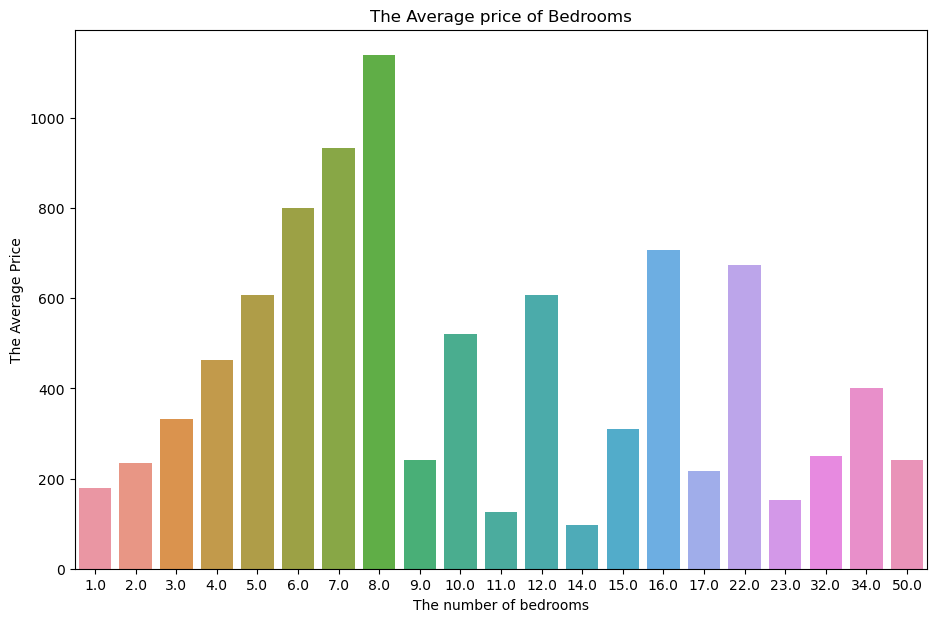

In [4]:
averagePriceByTheBedrooms = df.groupby('bedrooms')['priceIs'].mean().reset_index()

plt.figure(figsize=(11, 7))
sns.barplot(x='bedrooms', y='priceIs', data=averagePriceByTheBedrooms)
plt.title('The Average price of Bedrooms')
plt.xlabel('The number of bedrooms')
plt.ylabel('The Average Price')

plt.show()

Checking the null values present in each column

In [5]:
df.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
                                                ...  
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               22158
priceIs                                             0
Length: 76, dtype: int64

I dropped these columns as it did not add value in terms of predicting if a listing was good or bad. For some instances
I have combined columns together to make it one column. So that it adds in more value when its combined and is more insightful 

In [6]:
df = df.drop(["listing_url", "scrape_id", "last_scraped", "source",'description',
            "neighborhood_overview", "picture_url", "host_id", "host_url", "host_name", 
            "host_since", "host_location", "host_about", "host_thumbnail_url", "host_picture_url", 
             "neighbourhood_group_cleansed",  "calendar_updated",
            "license", "host_neighbourhood", "neighbourhood", "minimum_minimum_nights","maximum_minimum_nights", 
              "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm",
              "latitude", "longitude",
              "number_of_reviews_l30d", "calculated_host_listings_count_entire_homes",
              "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"
                  ], axis = 1)

Printing out the first 5 rows.

In [7]:
df.head()

,id,name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,priceIs
0,92644,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,NaN,NaN,100%,f,1.0,1.0,"['email', 'phone']",t,...,4.74,4.86,4.71,4.67,4.53,4.68,t,1,1.45,42.0
1,93015,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,within a few hours,100%,25%,f,1.0,2.0,"['email', 'phone']",t,...,4.76,4.62,4.85,4.88,4.85,4.74,f,1,0.27,175.0
2,13913,Rental unit in Islington · ★4.80 · 1 bedroom ·...,within a few hours,100%,88%,f,3.0,4.0,"['email', 'phone']",t,...,4.72,4.72,4.74,4.82,4.69,4.69,f,2,0.26,79.0
3,15400,Rental unit in London · ★4.80 · 1 bedroom · 1 ...,within a day,100%,41%,f,1.0,12.0,"['email', 'phone']",t,...,4.85,4.88,4.88,4.83,4.93,4.74,f,1,0.56,150.0
4,93734,Condo in London · ★4.62 · 1 bedroom · 1 bed · ...,within a few hours,90%,75%,t,1.0,1.0,"['email', 'phone']",t,...,4.70,4.59,4.63,4.81,4.64,4.67,f,1,1.21,46.0


Removing all the duplicates that are present in the dataset, same rows.

In [8]:
df = df[df.duplicated() == False]

 Over here I have created a function where im converting the dates to datetime format and taking the 
 calendar_last_scrapped and subtracting it with last_review so that i can see the duration of the review in days format.
 And then i dropped first_review, last_review and calendar_last_scrapped as it no longer adds value to my analysis.

In [9]:
def dateTimeReviews():
    df['calendar_last_scraped'] = pd.to_datetime(df['calendar_last_scraped'])
    df['last_review'] = pd.to_datetime(df['last_review'])
    df['reviewsInDays'] = (df['calendar_last_scraped'] - df['last_review']).dt.days
    
dateTimeReviews()
df = df.drop(["first_review", "last_review", "calendar_last_scraped"], axis = 1)  
df['reviewsInDays']

0        312.0
1        341.0
2        269.0
3        128.0
4          5.0
         ...  
87941      NaN
87942      NaN
87943      NaN
87944      NaN
87945      NaN
Name: reviewsInDays, Length: 87946, dtype: float64

It was important to remove the $, % and , from the price, host_response_rate and host_acceptance_rate columns and then
converting it into numeric format so that it an be later used to train the model without special characters as these
columns are important in my opinion.

In [10]:
def replacingAndExtracting():
    # Price 
    df['price'] = df['price'].astype(str).str.replace("$", "")
    df['price'] = df['price'].str.replace(",", "")
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # host_response_rate
    df['host_response_rate'] =  df['host_response_rate'].astype(str).str.replace("%", "")
    df['host_response_rate'] =  df['host_response_rate'].str.replace(",", "")
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')

    # host_acceptance_rate
    df['host_acceptance_rate'] =  df['host_acceptance_rate'].astype(str).str.replace("%", "")
    df['host_acceptance_rate'] =  df['host_acceptance_rate'].str.replace(",", "")
    df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'], errors='coerce')


replacingAndExtracting()

C:\Users\saadw\AppData\Local\Temp\ipykernel_1700\3517999632.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].astype(str).str.replace("$", "")


Over here im replacing the null values with either 0, false or not given. So over here for all the review columns, it was seen that where ever there were null values present. I looked at the other columns known as number_of_reviews, first_review and last_review. So in this case number_of_reviews was 0 and the first_review and last_review was empty. Which suggests that the user did not give a review of the apartment/house he/she stayed in. So in this case replacing the null values with 0 was the best option in my opinion. As taking the mean, median of the review columns would be inaccurate as the other columns would say otherwise. And for host_has_profile_pic, host_identity_verified and host_is_superhost, these were true or false values. So I replaced the null values with false as the data was not given. In addition, host_reponse_rate and host_acceptance_rate had null values as well, i replaced them with 0 as i do not know wht response and acceptance rate of the user and giving an average value or doing other techniques would be inaccurate so I decided to keep it as 0. The other columns followed the same concept.

In [11]:
def handlingNullValues(list, df):
    for i in list:
        if(i == "host_has_profile_pic" or i == "host_identity_verified" or i == "host_is_superhost"):
            df[i].fillna("f",inplace= True)
        if(i == "host_response_time"):
            df[i].fillna("Not Given", inplace = True)
        else:
            df[i].fillna(0,inplace= True)
            
list = ['host_listings_count', 'host_total_listings_count', 'host_has_profile_pic','host_identity_verified', 
           'review_scores_rating', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
            'reviews_per_month', 'host_response_rate','host_acceptance_rate', 'host_response_time', 
        'host_is_superhost', 'reviewsInDays'
       ]

handlingNullValues(list, df)

I dropped the bathrooms_text column here, even though it had bathrooms numbers which would be insightful but I thought of 
using regex techniques on the name column and extracting all the data at once.

In [12]:
df = df.drop(["bathrooms_text"], axis = 1)

Over here I created a function known as bathroomsRegex where I have passed a regex pattern and im searching the pattern from the name column. Im then extracting that data of numbers and filling it into the empty column known as bathrooms. As it is an important column and my goal is to fill all the columns one by one.

In [13]:
def bathroomsRegex():
    regexPatternOne = r"(\d+(\.\d+)?)\s*(shared baths|bath|private bath|shared|Private|bathroom|private|Shared half-bath|bathrooms|Bathroom|BATHROOM|Shared|Private half-bath|ensuite|Bathrooms)"
    
    for indexIs, data in df.iterrows():
        if pd.isna(data['bathrooms']):
            bathroomSearch = re.search(regexPatternOne, str(data['name']), re.IGNORECASE)
            if bathroomSearch is not None:
                df.at[indexIs, 'bathrooms'] = float(bathroomSearch.group(1))
            else:
                continue
bathroomsRegex()

It can be seen how the value has changed from being completely empty to 507 null values now, so the regex has worked 
quite well in this scenario

In [14]:
df.isnull().sum()

id                                    0
name                                  0
host_response_time                    0
host_response_rate                    0
host_acceptance_rate                  0
host_is_superhost                     0
host_listings_count                   0
host_total_listings_count             0
host_verifications                    0
host_has_profile_pic                  0
host_identity_verified                0
neighbourhood_cleansed                0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                           507
bedrooms                          32774
beds                               1134
amenities                             0
price                                 0
minimum_nights                        0
maximum_nights                        0
has_availability                      0
availability_30                       0
availability_60                       0


Over here im targetting to fill in the null values of bedrooms column, as it contains around 32774 null values. So the same steps apply of using a regex pattern and searching through the name column to fill in the null values as much as possible.

In [15]:
def bedroomsRegex():
    regexPatternTwo = r'(\d+)\s*(bedroom|bed room|bedrooms)'
    for indexIs, data in df.iterrows():
        if pd.isna(data['bedrooms']):
            bedroomSearch = re.search(regexPatternTwo, str(data['name']), re.IGNORECASE)
            if bedroomSearch is not None:
                df.at[indexIs, 'bedrooms'] = float(bedroomSearch.group(1))
            else:
                continue
bedroomsRegex()

Over here im doing the same steps where im applying the regex and searching for the beds to fill in the missing values from
the name column which has the data.It was seen earlier in the isnull().sum() function that it had 1134 null values which should be dealt with.

In [16]:
def bedsRegex():
    regexPatternThree = r'(\d+)\s*(beds|bed)'
    for indexIs, data in df.iterrows():
        if pd.isna(data['beds']):
            bed_match = re.search(regexPatternThree, data['name'], re.IGNORECASE)
            if bed_match is not None:
                df.at[indexIs, 'beds'] = int(bed_match.group(1))
            else:
                continue
bedsRegex()

It can be seen here that the number of null values has decreased by big amounts. It has took all the values from the name column and replaced it with the name column successfully. There are still some null values left and that is because for the name column there are instances where the beds,bedrooms and bathrooms dont have the data on the excel sheet, so thats why there are null values remaining.

In [17]:
df.isnull().sum()

id                                   0
name                                 0
host_response_time                   0
host_response_rate                   0
host_acceptance_rate                 0
host_is_superhost                    0
host_listings_count                  0
host_total_listings_count            0
host_verifications                   0
host_has_profile_pic                 0
host_identity_verified               0
neighbourhood_cleansed               0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                          507
bedrooms                          3637
beds                               202
amenities                            0
price                                0
minimum_nights                       0
maximum_nights                       0
has_availability                     0
availability_30                      0
availability_60                      0
availability_90          

For the remaining null values I replaced it with zero, as i thought that giving a overall average doesnt make sense, giving
it one can be inaccurate so i decided to replace the null values for beds,bedrooms and bathrooms with 0 as it was a safer
option, it basically meant that the data is not present.

In [18]:
def fillZeroForRemaining():
    
    df['beds'].fillna(0, inplace = True)
    df['bedrooms'].fillna(0, inplace = True)
    df['bathrooms'].fillna(0, inplace = True)
    
fillZeroForRemaining()   

It can be seen that the data cleaning part is dealt with, I have handled all the null values. 

In [19]:
df.isnull().sum()

id                                0
name                              0
host_response_time                0
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_listings_count               0
host_total_listings_count         0
host_verifications                0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_cleansed            0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities                         0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews           

Instead of taking all the reviews column seperately I thought of taking the average by adding all the reviews column and 
dividing it by 7 which was the total columns to get an overall score. 

In [20]:
def overallReviewScore():
    df['TotalReviewScore'] = (df['review_scores_rating'] + df['review_scores_accuracy'] + df['review_scores_cleanliness'] +
    df['review_scores_checkin'] + df['review_scores_communication'] + df['review_scores_location'] + 
                              df['review_scores_value'])/7
    df['TotalReviewScore'] = df['TotalReviewScore'].round(2)

overallReviewScore()

I then dropped these columns, name was used for regex and I no longer need it, same goes for all the reviews columns.

In [21]:
df = df.drop(['name','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'
             ], axis = 1)

Over here there was a column known as host_verifications it was a dictionary of phone, email, photographer and 
work_email. So I decided to make seperate columns on these four attributes and encode them with 1's and 0's based on if its
present in that specific row or not the 1's and 0's will then be assigned respectively, 

In [22]:
def extractingVerifications(featuresIs, verificationList):
 
    

    if('host_verifications' in df.columns):
        for i in df['host_verifications']:

            zeroList = np.zeros(len(featuresIs))

            if isinstance(i, str):
                try:
                    newList = ast.literal_eval(i)
                    if newList is None:  
                        newList = []
                except (ValueError, SyntaxError):
                    newList = []  # if errors are present, an empty list is present
            else:
                newList = []



            indexIs = 0
            if newList != None:
                while(indexIs < len(newList)):
                    amenity = newList[indexIs]
                    if amenity in featuresIs:
                        indexIs = featuresIs.index(amenity)
                        zeroList[indexIs] = 1
                    indexIs = indexIs + 1


            verificationList.append(zeroList)


featuresIs = ['email', 'phone', 'photographer', 'work_email']
verificationList = []
extractingVerifications(featuresIs, verificationList)
verificationDF = pd.DataFrame(verificationList, columns=['isEmail', 'isPhone', 'isPhotographer', 'isWork_Email'])

print(verificationDF.tail(30))

       isEmail  isPhone  isPhotographer  isWork_Email
87916      0.0      1.0             0.0           0.0
87917      1.0      1.0             0.0           0.0
87918      0.0      1.0             0.0           0.0
87919      1.0      1.0             0.0           0.0
87920      0.0      1.0             0.0           0.0
87921      1.0      1.0             0.0           0.0
87922      1.0      1.0             0.0           1.0
87923      1.0      1.0             0.0           0.0
87924      1.0      1.0             0.0           0.0
87925      1.0      1.0             0.0           0.0
87926      1.0      1.0             0.0           1.0
87927      1.0      1.0             0.0           0.0
87928      0.0      1.0             0.0           0.0
87929      1.0      1.0             0.0           0.0
87930      1.0      1.0             0.0           0.0
87931      1.0      1.0             0.0           1.0
87932      1.0      1.0             0.0           0.0
87933      1.0      1.0     

I want to pull the data of the verifications encoded values to the existing dataframe as it is in a seperate dataframe. So,
I took the unique id present in the existing dataframe and fed it to the verificationDF so that later i can merge the two
dataframes together by id as it requires a unique value.

In [23]:
idCol = df.iloc[:, 0] 
df['id'] = idCol
verificationDF['id'] = df['id']

In [24]:
verificationDF

,isEmail,isPhone,isPhotographer,isWork_Email,id
0,1.0,1.0,0.0,0.0,92644
1,1.0,1.0,0.0,0.0,93015
2,1.0,1.0,0.0,0.0,13913
3,1.0,1.0,0.0,0.0,15400
4,1.0,1.0,0.0,0.0,93734
...,...,...,...,...,...
87941,0.0,1.0,0.0,0.0,973781286754517228
87942,1.0,1.0,0.0,0.0,973801695874775338
87943,1.0,1.0,0.0,0.0,973811685656289740
87944,1.0,1.0,0.0,0.0,973882998775927897


In [25]:
df = pd.merge(df,verificationDF, on = ["id"])

It has been successfully merged into one column

In [26]:
df

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,instant_bookable,calculated_host_listings_count,reviews_per_month,priceIs,reviewsInDays,TotalReviewScore,isEmail,isPhone,isPhotographer,isWork_Email
0,92644,Not Given,0.0,100.0,f,1.0,1.0,"['email', 'phone']",t,t,...,t,1,1.45,42.0,312.0,4.68,1.0,1.0,0.0,0.0
1,93015,within a few hours,100.0,25.0,f,1.0,2.0,"['email', 'phone']",t,t,...,f,1,0.27,175.0,341.0,4.79,1.0,1.0,0.0,0.0
2,13913,within a few hours,100.0,88.0,f,3.0,4.0,"['email', 'phone']",t,t,...,f,2,0.26,79.0,269.0,4.74,1.0,1.0,0.0,0.0
3,15400,within a day,100.0,41.0,f,1.0,12.0,"['email', 'phone']",t,t,...,f,1,0.56,150.0,128.0,4.84,1.0,1.0,0.0,0.0
4,93734,within a few hours,90.0,75.0,t,1.0,1.0,"['email', 'phone']",t,t,...,f,1,1.21,46.0,5.0,4.67,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87941,973781286754517228,within an hour,100.0,100.0,t,2.0,2.0,['phone'],t,t,...,f,2,0.00,275.0,0.0,0.00,0.0,1.0,0.0,0.0
87942,973801695874775338,Not Given,0.0,0.0,f,1.0,1.0,"['email', 'phone']",t,t,...,f,1,0.00,145.0,0.0,0.00,1.0,1.0,0.0,0.0
87943,973811685656289740,within an hour,100.0,98.0,f,1.0,1.0,"['email', 'phone']",t,t,...,f,1,0.00,160.0,0.0,0.00,1.0,1.0,0.0,0.0
87944,973882998775927897,within an hour,81.0,99.0,f,2538.0,5217.0,"['email', 'phone']",t,t,...,t,170,0.00,680.0,0.0,0.00,1.0,1.0,0.0,0.0


In [27]:
colIndex = df.columns.get_loc('host_verifications')
colIndex

7

In [28]:
df.iloc[87916, 6]

1.0

I made a function here which will count the top 5 most important amenities by count. To which kitchen, wifi,smoke alarm, 
essentials and iron were present with the highest counts. Because I will later encode them by making seperate columns for it

In [29]:
def extractingMostCountAmenities():
    amenitiesData = df['amenities']
    extractAmenities = []
    amenitiesList = amenitiesData.apply(ast.literal_eval)

    extractAmenities = []
    if amenitiesData is not None:
        for i in amenitiesList:
            indexIs = 0
            while(indexIs < len(i)):
                extractAmenities.append(i[indexIs])
                indexIs = indexIs + 1 

    totalCount = Counter(extractAmenities)


    topTenList = totalCount.most_common(5)
    for i in topTenList:
        print(i)
extractingMostCountAmenities()

('Kitchen', 80119)
('Wifi', 79856)
('Smoke alarm', 78620)
('Essentials', 73523)
('Iron', 62614)


This function will extract the top 5 amenities which I have given as a list. It will have seperate columns encoded with
1's and 0's. As well as OtherAmenities which will take the count of the remaining amenities of each row.

In [30]:
def extractingAmenitiesAndOthers(importantAmenities, countOthers, amenitiesIs):


    if('amenities' in df.columns):
        for i in df['amenities']:

            zeroList = np.zeros(len(importantAmenities))
            countIs = 0
            if isinstance(i, str):
                try:
                    newList = ast.literal_eval(i)
                except (ValueError, SyntaxError):
                    newList = []  
            else:
                newList = i

            indexIs = 0
            if newList != None:
                while(indexIs < len(newList)):
                    amenity = newList[indexIs]
                    if amenity in importantAmenities:
                        index = importantAmenities.index(amenity)
                        zeroList[index] = 1

                    else:
                        countIs = countIs + 1

                    indexIs = indexIs + 1

                amenitiesIs.append(zeroList)
                countOthers.append(countIs)

                
importantAmenities = ['Kitchen', 'Wifi', 'Smoke alarm', 'Essentials', 'Iron', 
                      ]
countOthers = []
amenitiesIs = []                
extractingAmenitiesAndOthers(importantAmenities, countOthers, amenitiesIs)         
                
df_encoded = pd.DataFrame(amenitiesIs, columns=importantAmenities)
df_encoded1 = pd.DataFrame(countOthers, columns=["OtherAmenities"])
df_encoded.head()


,Kitchen,Wifi,Smoke alarm,Essentials,Iron
0,1.0,1.0,1.0,1.0,0.0
1,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


In [31]:
df_encoded1.head()

,OtherAmenities
0,4
1,44
2,50
3,20
4,41


Over here im merging the two dataframes with unique id and then i will later merge them to the existing column df.

In [32]:
idCol = df.iloc[:, 0] 
df['id'] = idCol
df_encoded['id'] = df['id']
df_encoded1['id'] = df['id']

In [33]:
df3 = pd.merge(df_encoded,df_encoded1, on = ["id"])

In [34]:
df = pd.merge(df,df3, on = ["id"])

In [35]:
df = df.drop(["amenities", "id", 'host_verifications']
, axis = 1)

In [36]:
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,...,isEmail,isPhone,isPhotographer,isWork_Email,Kitchen,Wifi,Smoke alarm,Essentials,Iron,OtherAmenities
0,Not Given,0.0,100.0,f,1.0,1.0,t,t,Wandsworth,Private room in rental unit,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4
1,within a few hours,100.0,25.0,f,1.0,2.0,t,t,Hammersmith and Fulham,Entire rental unit,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,44
2,within a few hours,100.0,88.0,f,3.0,4.0,t,t,Islington,Private room in rental unit,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,50
3,within a day,100.0,41.0,f,1.0,12.0,t,t,Kensington and Chelsea,Entire rental unit,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,20
4,within a few hours,90.0,75.0,t,1.0,1.0,t,t,Greenwich,Private room in condo,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,41


Before training the model it is important to convert t and f which is true and false to binary outputs as it will make it 
easy for the model to understand, as it understands numbers. 

In [37]:
def encodingColumns():
    df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'t': 1, 'f': 0})
    df['host_identity_verified'] = df['host_identity_verified'].map({'t': 1, 'f': 0})
    df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
    df['has_availability'] = df['has_availability'].map({'t': 1, 'f': 0})
    df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})
encodingColumns()

I have made some new features from the existing features that will be used in the creation of the formula of producing if 
the listing was good or bad based on a score. 

In [38]:
def FeatureEngineering():

    df['averagePriceForNeighbourhood'] = df.groupby('neighbourhood_cleansed')['price'].transform('mean')
    df['averagePriceForNeighbourhood'] =  df['averagePriceForNeighbourhood'].round(2)
    #----------------------------------------------------------------------------------
    df['verificationStatus'] = df['isEmail'] + df['isPhone'] + df['isPhotographer'] + df['isWork_Email']
    #----------------------------------------------------------------------------------
    scoreIs = 10  
    df['bookingScoreOfMinMaxNights'] = ((scoreIs - df['minimum_nights']) + df['maximum_nights']) / 2
    #----------------------------------------------------------------------------------
    epsilon = 1e-4  # this is used to avoid the usage of zero division. 
    df['bedsPerBedroomsPlusBathrooms'] = df['beds'] / (df['bedrooms'] + df['bathrooms'] + epsilon)
    #----------------------------------------------------------------------------------
    df['hostDataBinary'] = (df['host_has_profile_pic'] + df['host_identity_verified'] + df['host_is_superhost']) / 3
    #----------------------------------------------------------------------------------
    df['availabilityAndBookable'] = df['has_availability'] + df['instant_bookable'] / 2
    #----------------------------------------------------------------------------------
    weights = {
        'availability_90': 0.2,
        'availability_365': 0.1,
        'availability_30': 0.4,
        'availability_60': 0.3
         }

    df['availableScore'] = (
        (df['availability_30'] / 30) * 0.4 + 
        ((df['availability_60'] - df['availability_30']) / 30) * 0.3 +
        ((df['availability_90'] - df['availability_60']) / 30) * 0.2 +
        (df['availability_365'] / 365) * 0.1) * 100
  
    #-----------------------------------------------------------------------------------
  
   
FeatureEngineering()

# Normalizing Columns and Creating Formula for Prediction

Before assigning weights to each column it is important to normalize all the columns that ill be using in the formula, from
0 to 100. 

In [39]:
def normalizing():
    
    max_score = df['averagePriceForNeighbourhood'].max()
    df['averagePriceForNeighbourhood'] = df['averagePriceForNeighbourhood'] / max_score
    df['averagePriceForNeighbourhood']
    
    max_score1 = df['host_response_rate'].max()
    df['host_response_rate'] = df['host_response_rate'] / max_score1
    df['host_response_rate']
    
    max_score2 = df['host_acceptance_rate'].max()
    df['host_acceptance_rate'] = df['host_acceptance_rate'] / max_score2
    df['host_acceptance_rate']
    
    max_score3 = df['TotalReviewScore'].max()
    df['TotalReviewScore'] = df['TotalReviewScore'] / max_score3
    df['TotalReviewScore']
    
    
    max_score5 = df['number_of_reviews_ltm'].max()
    df['number_of_reviews_ltm'] = df['number_of_reviews_ltm'] / max_score5
    df['number_of_reviews_ltm']

    
    max_score6 = df['hostDataBinary'].max()
    df['hostDataBinary'] = df['hostDataBinary'] / max_score6
    df['hostDataBinary']
    
    max_score6 = df['availabilityAndBookable'].max()
    df['availabilityAndBookable'] = df['availabilityAndBookable'] / max_score6
    df['availabilityAndBookable']
    
    max_score6 = df['bedsPerBedroomsPlusBathrooms'].max()
    df['bedsPerBedroomsPlusBathrooms'] = df['bedsPerBedroomsPlusBathrooms'] / max_score6
    df['bedsPerBedroomsPlusBathrooms']
    
    max_score7 = df['availableScore'].max()
    df['availableScore'] = df['availableScore'] / max_score7
    df['availableScore']
    

    
normalizing()    

In [40]:
df

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,...,Essentials,Iron,OtherAmenities,averagePriceForNeighbourhood,verificationStatus,bookingScoreOfMinMaxNights,bedsPerBedroomsPlusBathrooms,hostDataBinary,availabilityAndBookable,availableScore
0,Not Given,0.00,1.00,0,1.0,1.0,1,1,Wandsworth,Private room in rental unit,...,1.0,0.0,4,0.522693,2.0,369.0,0.000016,0.666667,1.000000,0.059452
1,within a few hours,1.00,0.25,0,1.0,2.0,1,1,Hammersmith and Fulham,Entire rental unit,...,1.0,1.0,44,0.552824,2.0,122.5,0.000020,0.666667,0.666667,0.367626
2,within a few hours,1.00,0.88,0,3.0,4.0,1,1,Islington,Private room in rental unit,...,1.0,1.0,50,0.540160,2.0,19.0,0.000010,0.666667,0.666667,0.931963
3,within a day,1.00,0.41,0,1.0,12.0,1,1,Kensington and Chelsea,Entire rental unit,...,1.0,1.0,20,0.958951,2.0,16.5,0.000010,0.666667,0.666667,0.113333
4,within a few hours,0.90,0.75,1,1.0,1.0,1,1,Greenwich,Private room in condo,...,1.0,1.0,41,0.380548,2.0,185.5,0.000010,1.000000,0.666667,0.120365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87941,within an hour,1.00,1.00,1,2.0,2.0,1,1,Westminster,Entire rental unit,...,1.0,0.0,32,1.000000,1.0,566.5,0.000020,1.000000,0.666667,0.178813
87942,Not Given,0.00,0.00,0,1.0,1.0,1,1,Southwark,Entire rental unit,...,1.0,0.0,37,0.563368,2.0,14.0,0.000010,0.666667,0.666667,0.897443
87943,within an hour,1.00,0.98,0,1.0,1.0,1,1,Merton,Private room in home,...,1.0,1.0,59,0.477931,2.0,27.0,0.000033,0.666667,0.666667,0.795251
87944,within an hour,0.81,0.99,0,2538.0,5217.0,1,1,Hounslow,Entire home,...,1.0,1.0,17,0.569138,2.0,187.0,0.000017,0.666667,1.000000,0.986393


Over here im encoding room_type and host_response_time into numbers before training the model. 

In [41]:
encode = LabelEncoder()
df['room_type'] = encode.fit_transform(df['room_type'])
df['host_response_time'] = encode.fit_transform(df['host_response_time'])

This is the process of creating the formula, I have given total review score which is the overall review the highest weight
as in my opinion I found it to be the most important column, and then ive given other weights based on importance. After 
that is done I used the 75th quantile and set a threshold using if else statements. If the value is greater than the 
threshold I have assigned it to 1 or else its assigned to 0 using the lambda function. 

In [42]:


# Giving weights to columns 
weights = {
    'TotalReviewScore': 0.20,
    'availableScore' : 0.10,
    'number_of_reviews_ltm': 0.10, 
    'host_response_rate': 0.15, 
    'host_acceptance_rate': 0.15, 
    'bedsPerBedroomsPlusBathrooms': 0.10,
    'hostDataBinary': 0.05,
    'availabilityAndBookable' : 0.05,
    'averagePriceForNeighbourhood': 0.10, 
  
}

# Finding the weighted sum 
df['ScoreIs'] = (
    
    0.20 * df['TotalReviewScore'] +
    0.10 * df['availableScore'] +
    0.10 * df['number_of_reviews_ltm'] +
    0.15 * df['host_response_rate'] +
    0.15 * df['host_acceptance_rate']+
    0.10 * df['averagePriceForNeighbourhood']+
    0.05 * df['hostDataBinary'] +
    0.05 * df['availabilityAndBookable']+ 
    0.10 * df['bedsPerBedroomsPlusBathrooms']
 
    

)

thresholdIs = df['ScoreIs'].quantile(0.75)

df['Binary'] = df['ScoreIs'].apply(lambda x: 1 if x >= thresholdIs else 0)


In [43]:
df['Binary'].unique(), df['Binary'].value_counts()

(array([0, 1], dtype=int64),
 0    65959
 1    21987
 Name: Binary, dtype: int64)

In [46]:
ScoreOutput = df['Binary']
ScoreOutput

0        0
1        0
2        1
3        0
4        0
        ..
87941    0
87942    0
87943    0
87944    0
87945    0
Name: Binary, Length: 87946, dtype: int64

In [44]:
newdf = df[['TotalReviewScore', 'availableScore', 'number_of_reviews_ltm', 'host_response_rate', 'host_acceptance_rate',
           'averagePriceForNeighbourhood', 'hostDataBinary', 'availabilityAndBookable', 'bedsPerBedroomsPlusBathrooms'
           ]]

In [45]:
newdf

,TotalReviewScore,availableScore,number_of_reviews_ltm,host_response_rate,host_acceptance_rate,averagePriceForNeighbourhood,hostDataBinary,availabilityAndBookable,bedsPerBedroomsPlusBathrooms
0,0.936,0.059452,0.015152,0.00,1.00,0.522693,0.666667,1.000000,0.000016
1,0.958,0.367626,0.003367,1.00,0.25,0.552824,0.666667,0.666667,0.000020
2,0.948,0.931963,0.018519,1.00,0.88,0.540160,0.666667,0.666667,0.000010
3,0.968,0.113333,0.008418,1.00,0.41,0.958951,0.666667,0.666667,0.000010
4,0.934,0.120365,0.042088,0.90,0.75,0.380548,1.000000,0.666667,0.000010
...,...,...,...,...,...,...,...,...,...
87941,0.000,0.178813,0.000000,1.00,1.00,1.000000,1.000000,0.666667,0.000020
87942,0.000,0.897443,0.000000,0.00,0.00,0.563368,0.666667,0.666667,0.000010
87943,0.000,0.795251,0.000000,1.00,0.98,0.477931,0.666667,0.666667,0.000033
87944,0.000,0.986393,0.000000,0.81,0.99,0.569138,0.666667,1.000000,0.000017


I have implemented Logistic Regression and it can be seen that there is an accuracy of 99 to 98 %

In [47]:
from sklearn.model_selection import train_test_split 

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(newdf,ScoreOutput,test_size = 0.2)

In [67]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_predTrain = model.predict(X_train)

In [69]:
y_predTest = model.predict(X_test)

In [70]:
accuracyTest = accuracy_score(Y_test, y_predTest)

In [71]:
accuracyTest

0.9939169982944855

In [72]:
accuracyTrain = accuracy_score(Y_train, y_predTrain)

In [73]:
accuracyTrain

0.9945704701802263

In [74]:
def performingMetricsForRegression():
    
    # Testing Results 
    
    y_predictTest = model.predict(X_test)
    confusionMatrix = confusion_matrix(Y_test, y_predictTest)
    accuracyIs = accuracy_score(Y_test, y_predictTest)
    precisionIs = precision_score(Y_test, y_predictTest)
    recallIs = recall_score(Y_test, y_predictTest)
    f1Is = f1_score(Y_test, y_predictTest)

    print("Confusion Matrix(Testing):\n", confusionMatrix)
    print("Accuracy(Testing):", accuracyIs)
    print("Precision(Testing):", precisionIs)
    print("Recall(Testing):", recallIs)
    print("F1 Score(Testing):", f1Is)

    
    # Training Results 
    
    
    y_predictTrain = model.predict(X_train)
    confusionMatris1 = confusion_matrix(Y_train, y_predictTrain)
    accuracyIs1 = accuracy_score(Y_train, y_predictTrain)
    precisionIs1 = precision_score(Y_train, y_predictTrain)
    recallIs1 = recall_score(Y_train, y_predictTrain)
    f1Is1 = f1_score(Y_train, y_predictTrain)

    print("Confusion Matrix(Training):\n", confusionMatris1)
    print("Accuracy(Training):", accuracyIs1)
    print("Precision(Training):", precisionIs1)
    print("Recall(Training):", recallIs1)
    print("F1 Score(Training):", f1Is1)
    
performingMetricsForRegression()

Confusion Matrix(Testing):
 [[13165    48]
 [   59  4318]]
Accuracy(Testing): 0.9939169982944855
Precision(Testing): 0.98900595510765
Recall(Testing): 0.9865204477952936
F1 Score(Testing): 0.9877616378817339
Confusion Matrix(Training):
 [[52550   196]
 [  186 17424]]
Accuracy(Training): 0.9945704701802263
Precision(Training): 0.9888762769580023
Recall(Training): 0.9894378194207837
F1 Score(Training): 0.9891569684927619
